# IPL Match Prediction Project

## Data Cleaning and Preperation:

In [3]:
# importing the necessary libraries required for the project
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt 

# setting the default Seaborn style for graphics
sb.set() 

In [4]:
# reading csv files and storing them as dataframes
ball_data = pd.read_csv('ball_data.csv')
match_data = pd.read_csv('match_data.csv')

In [5]:
ball_data

,id,inning,over,ball,batsman,non_striker,bowler,batsman_runs,extra_runs,total_runs,non_boundary,is_wicket,dismissal_kind,player_dismissed,fielder,extras_type,batting_team,bowling_team
0,335982,1,6,5,RT Ponting,BB McCullum,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
1,335982,1,6,6,BB McCullum,RT Ponting,AA Noffke,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
2,335982,1,7,1,BB McCullum,RT Ponting,Z Khan,0,0,0,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
3,335982,1,7,2,BB McCullum,RT Ponting,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
4,335982,1,7,3,RT Ponting,BB McCullum,Z Khan,1,0,1,0,0,NaN,NaN,NaN,NaN,Kolkata Knight Riders,Royal Challengers Bangalore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193463,1237181,1,12,5,RR Pant,SS Iyer,NM Coulter-Nile,0,0,0,0,0,NaN,NaN,NaN,NaN,Delhi Capitals,Mumbai Indians
193464,1237181,1,12,6,RR Pant,SS Iyer,NM Coulter-Nile,1,0,1,0,0,NaN,NaN,NaN,NaN,Delhi Capitals,Mumbai Indians
193465,1237181,1,13,1,RR Pant,SS Iyer,KH Pandya,0,1,1,0,0,NaN,NaN,NaN,wides,Delhi Capitals,Mumbai Indians
193466,1237181,1,13,2,RR Pant,SS Iyer,KH Pandya,1,0,1,0,0,NaN,NaN,NaN,NaN,Delhi Capitals,Mumbai Indians


In [6]:
# removing abandoned games which act as outliers in the data
l=[]
number_of_matches = match_data.shape[0]
for index in range(0,number_of_matches):
    if(pd.isnull(match_data['winner'][index])):
        l.append(match_data['id'][index])      
for match_id in l:
    ball_data.drop(ball_data[ball_data['id'] == match_id].index, inplace = True)

    
# sorting data and resetting index after sorting
ball_data.sort_values(['id', 'inning', 'over', 'ball']).reset_index(drop=True, inplace=True)

### Main Data Preperation Loop

In [7]:
# initialising predictor variable dataframe as 0 to know when to form it/concatenate it later
predictor_vars = 0

# Grouping the data by match and then by each inning
by_match_inning = ball_data.groupby(['id', 'inning'])

        
# looping through the groupby object where key is a tuple containing ('id', 'inning') for each inning dataframe
for key, inning in by_match_inning:
    
    # getting 3/4 of the innings data(used for prediction) and creating team_score variable for each inning at 3/4 inning mark
    inning = inning.sort_values(by=['over', 'ball']).reset_index(drop=True)
    inning['team_score'] = inning['total_runs'].cumsum()
    score = inning['team_score'].iloc[-1] 
    ratio = round(inning['over'].iloc[-1]*75/100)
    index = inning.index[inning['over']==ratio].tolist()
    inning = pd.DataFrame(inning.iloc[:index[-1]])
    
        
    # creating 'wickets_left', 'final_score', 'team_score' variables in the temporary dataframe
    inning_data_df = pd.DataFrame(columns=['wickets_left', 'id', 'inning', 'team_score', 'final_score'])
    inning_data_df['wickets_left'] = inning['is_wicket'].cumsum()
    inning_data_df['team_score'] = inning['total_runs'].cumsum()
    inning_data_df = inning_data_df.iloc[-1].copy()
    inning_data_df['wickets_left'] = int(10-inning_data_df['wickets_left'])
    inning_data_df['id'] = int(key[0])
    inning_data_df['inning'] = int(key[1])
    inning_data_df['final_score'] = int(score)
    inning_data_df['team_score'] = int(inning_data_df['team_score'])
    inning_data_df = pd.DataFrame(inning_data_df).transpose().reset_index(drop=True)
    
    
    # getting bowler stats from the dataframe by grouping by bowler and then overs in each inings
    group_by_bowler = inning.groupby(['bowler'])
    bowler_data_df = pd.DataFrame(columns=['name', 'balls_bowled', 'overs_left', 'economy', 'runs_conceded'])
    
    for bowler_name, bowler_overs in group_by_bowler:

        # finding number of overs
        group_by_over = bowler_overs.groupby(['over'])
        overs_no = 0
        for overkey, over in group_by_over:
            overs_no+=1
        
        # not including the bowler's data if they have already bowled 4 (maximum no. permitted) overs
        if overs_no >= 4:
            continue
            
        # finding bowler data for each bowler in the inning
        runs_given = bowler_overs['total_runs'].sum()
        bowler_data_dict = {'name':[bowler_name], 'balls_bowled':[bowler_overs.shape[0]], 'overs_left':[4 - overs_no], 'economy':[runs_given / overs_no], 'runs_conceded':[runs_given]}
        bowler_data_df = pd.concat([bowler_data_df, pd.DataFrame(bowler_data_dict)])
    bowler_data_df['total_overs'] = bowler_data_df['overs_left'].cumsum()
           
    # resetting index and sorting values of all bowler data from the inning
    bowler_data_df = bowler_data_df.reset_index(drop=True).sort_values(by=['economy'])

    # finding the average economy of the most economical bowlers who have overs left
    total_avg = 0
    bowler_ratio = round(inning['over'].iloc[-1]*25/100)+1
    for index in range(0, bowler_data_df.shape[0]):
        if(bowler_data_df['total_overs'][index]<bowler_ratio):
            total_avg += bowler_data_df['overs_left'][index]*bowler_data_df['economy'][index]
            
        elif(bowler_data_df['total_overs'][index]==bowler_ratio):
            total_avg += bowler_data_df['overs_left'][index]*bowler_data_df['economy'][index]
            break
            
        elif(bowler_data_df['total_overs'][index]>bowler_ratio):
            if index == 0:
                total_avg += (bowler_ratio*bowler_data_df['economy'][index])
            else:
                total_avg += (bowler_ratio-bowler_data_df['total_overs'][index-1])*bowler_data_df['economy'][index]
            break
    total_avg = total_avg/bowler_ratio

    
    # creating a column with the weighted economy of the bowlers
    bowler_data_dict = {'w_economy':[total_avg]}
    bowler_data_df = pd.DataFrame(bowler_data_dict)
    
    # concatenating bowler data to innings data which has other predictor variables for the inning
    inning_data_df = pd.concat([inning_data_df, bowler_data_df], axis = 1)
    
        
    #  getting batsman data
    no_rows = inning.shape[0]
    b1 = inning.loc[no_rows-1,'batsman']
    b2 = inning.loc[no_rows-1,'non_striker']
    b1_runs = b2_runs = b1_balls = b2_balls = 0
    
    # calculating runs scored by the current batsmen and balls faced by each batsman
    for i in range(0,inning.shape[0]):
        if(inning['batsman'][i]==b1):
            b1_balls+=1
            b1_runs+=inning['batsman_runs'][i]
        elif(inning['batsman'][i]==b2):
            b2_balls+=1
            b2_runs+=inning['batsman_runs'][i]
        else:
            continue
    
    # making strike rate zero if zero balls faced
    if(b1_balls == 0):
        b1_sr = 0
    else:
        b1_sr = b1_runs/b1_balls
        
    if(b2_balls == 0):
        b2_sr = 0
    else:
        b2_sr = b2_runs/b2_balls
    
    # calculating average strike rate and average runs of the batsmen
    avg_sr = 100*(b1_sr + b2_sr)/2
    avg_runs = (b1_runs + b2_runs)/2

    # creating a column with the batsmens' stats
    batsman_data_dict = {'average_strike_rate':[avg_sr],'average_runs':[avg_runs]}
    batsman_data_df = pd.DataFrame(batsman_data_dict)
    
    
    # concatenating batsman data to innings data which has other predictor variables for the inning   
    inning_data_df = pd.concat([inning_data_df, batsman_data_df], axis=1)
    
    
    # concatenating each inning data to predictor variable data which has other predictor variables for all the innings    
    # initially predictors is set to 0, then becomes a dataframe with the data after first iteration of the for loop
    if(type(predictor_vars)==int):
        predictor_vars = pd.DataFrame()
        predictor_vars = pd.concat([predictor_vars, inning_data_df], axis=0)
    else:
        predictor_vars = pd.concat([predictor_vars, inning_data_df], axis=0)
    
# re-organising the columns in the predictor variable dataframe
first_column = predictor_vars.pop('id')
predictor_vars.insert(0, 'id', first_column)
first_column = predictor_vars.pop('inning')
predictor_vars.insert(1, 'inning', first_column)
last_column = predictor_vars.pop('final_score')
predictor_vars.insert(7, 'final_score', last_column)
predictor_vars = pd.DataFrame(predictor_vars.reset_index(drop=True))
# making all the variables integers
predictor_vars = predictor_vars.astype({'final_score':'int', 'wickets_left':'int', 'team_score':'int', 'average_runs':'int', 'average_strike_rate':'int' })

In [8]:
# checking the correlation matrix of the to see how well the created variables relate with the 'final_score' variable
predictor_vars.corr()

,wickets_left,team_score,w_economy,average_strike_rate,average_runs,final_score
wickets_left,1.000000,0.362465,0.300099,0.358958,0.594837,0.354835
team_score,0.362465,1.000000,0.509609,0.440217,0.431427,0.875774
w_economy,0.300099,0.509609,1.000000,0.305019,0.312084,0.387205
average_strike_rate,0.358958,0.440217,0.305019,1.000000,0.568344,0.396568
average_runs,0.594837,0.431427,0.312084,0.568344,1.000000,0.404592
final_score,0.354835,0.875774,0.387205,0.396568,0.404592,1.000000


## Basic Statistic Exploration and Visualisation on created variables

In [9]:
final_scoredf = pd.DataFrame(predictor_vars['final_score'])
x_vars = pd.DataFrame(predictor_vars.drop(['final_score', 'id', 'inning'], axis=1))

In [10]:
# Summary Statistics for the Response variable
final_scoredf.describe()

,final_score
count,1624.000000
mean,155.323892
std,30.778136
min,44.000000
25%,136.000000
50%,157.000000
75%,176.000000
max,263.000000


In [11]:
# Summary Statistics for Predictors
x_vars.describe()

,wickets_left,team_score,w_economy,average_strike_rate,average_runs
count,1624.000000,1624.000000,1624.000000,1624.000000,1624.000000
mean,6.495690,109.385468,8.168430,109.136700,22.761700
std,1.638261,21.794575,2.554517,37.674741,14.805054
min,1.000000,31.000000,2.000000,0.000000,0.000000
25%,5.000000,96.000000,6.533333,84.000000,11.000000
50%,7.000000,110.000000,7.866667,108.000000,21.000000
75%,8.000000,123.000000,9.400000,130.000000,32.000000
max,10.000000,190.000000,37.000000,362.000000,81.000000


<AxesSubplot:>

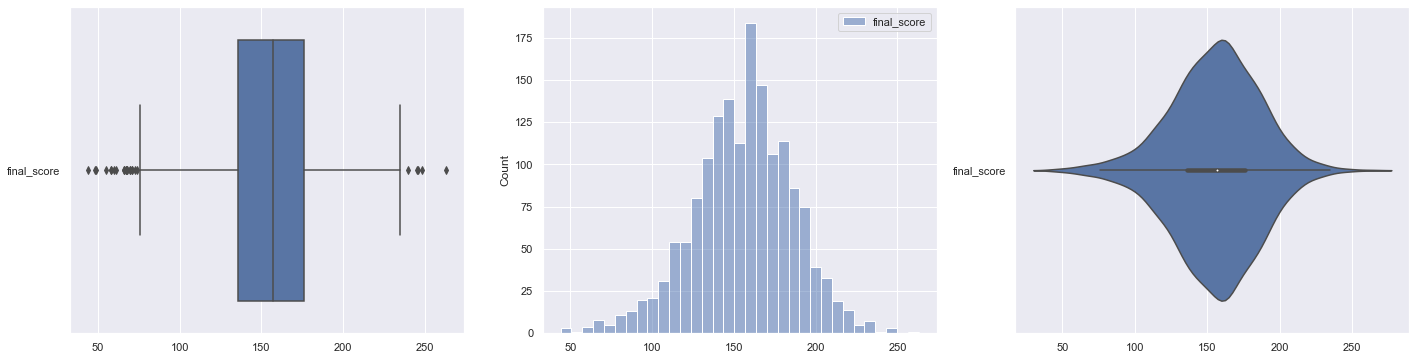

In [12]:
# Drawing the distribution of Response variable
f, axes = plt.subplots(1, 3, figsize=(24, 6))
sb.boxplot(data = final_scoredf, orient = "h", ax = axes[0])
sb.histplot(data = final_scoredf, ax = axes[1])
sb.violinplot(data = final_scoredf, orient = "h", ax = axes[2])

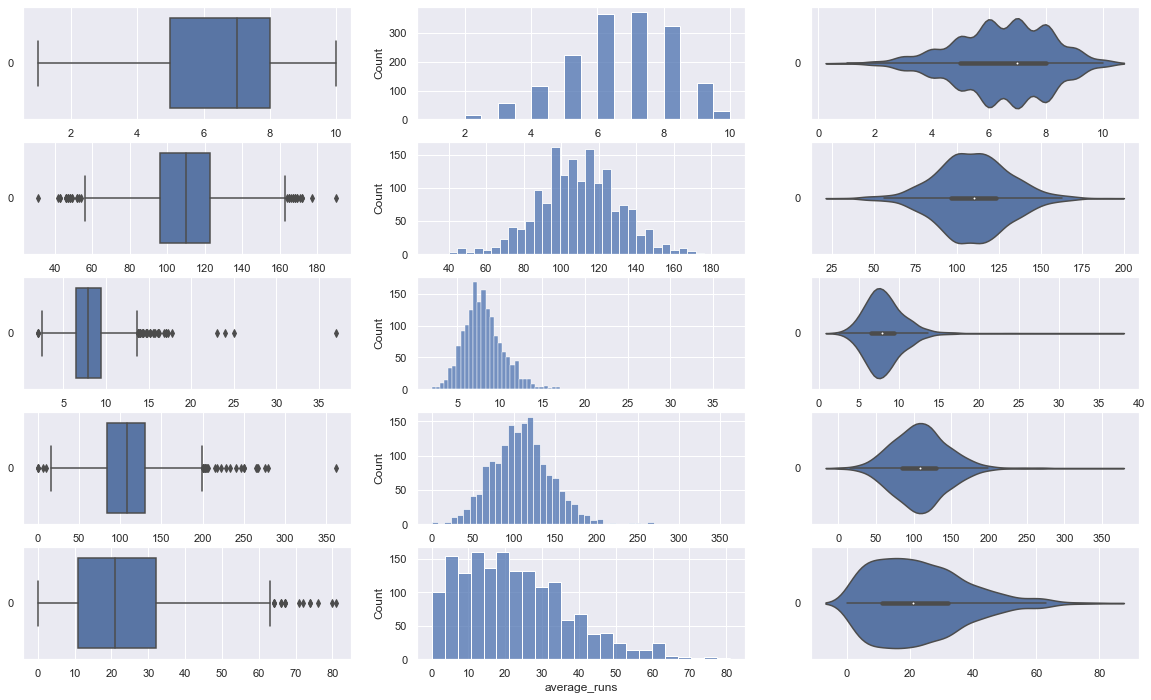

In [13]:
# Drawing the distributions of all Predictor variables
f, axes = plt.subplots(5, 3, figsize=(20, 12))
count = 0
num = 0
for var in x_vars:
    sb.boxplot(data = x_vars[var], orient = "h", ax = axes[count,num])
    num+=1
    sb.histplot(data = x_vars[var], ax = axes[count,num])
    num+=1
    sb.violinplot(data = x_vars[var], orient = "h", ax = axes[count,num])
    num = 0
    count += 1

<AxesSubplot:>

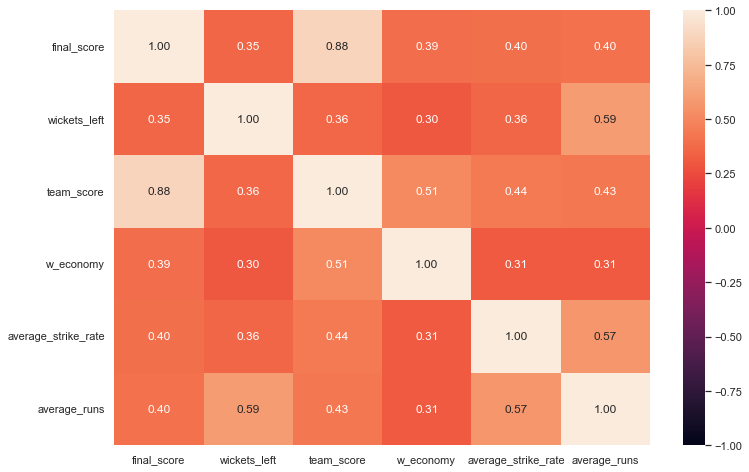

In [14]:
# Finding the correlation matrix between Response variable and the Predictor variables
trainDF = pd.concat([final_scoredf, x_vars], axis = 1).reindex(final_scoredf.index)

f = plt.figure(figsize=(12, 8))
sb.heatmap(trainDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

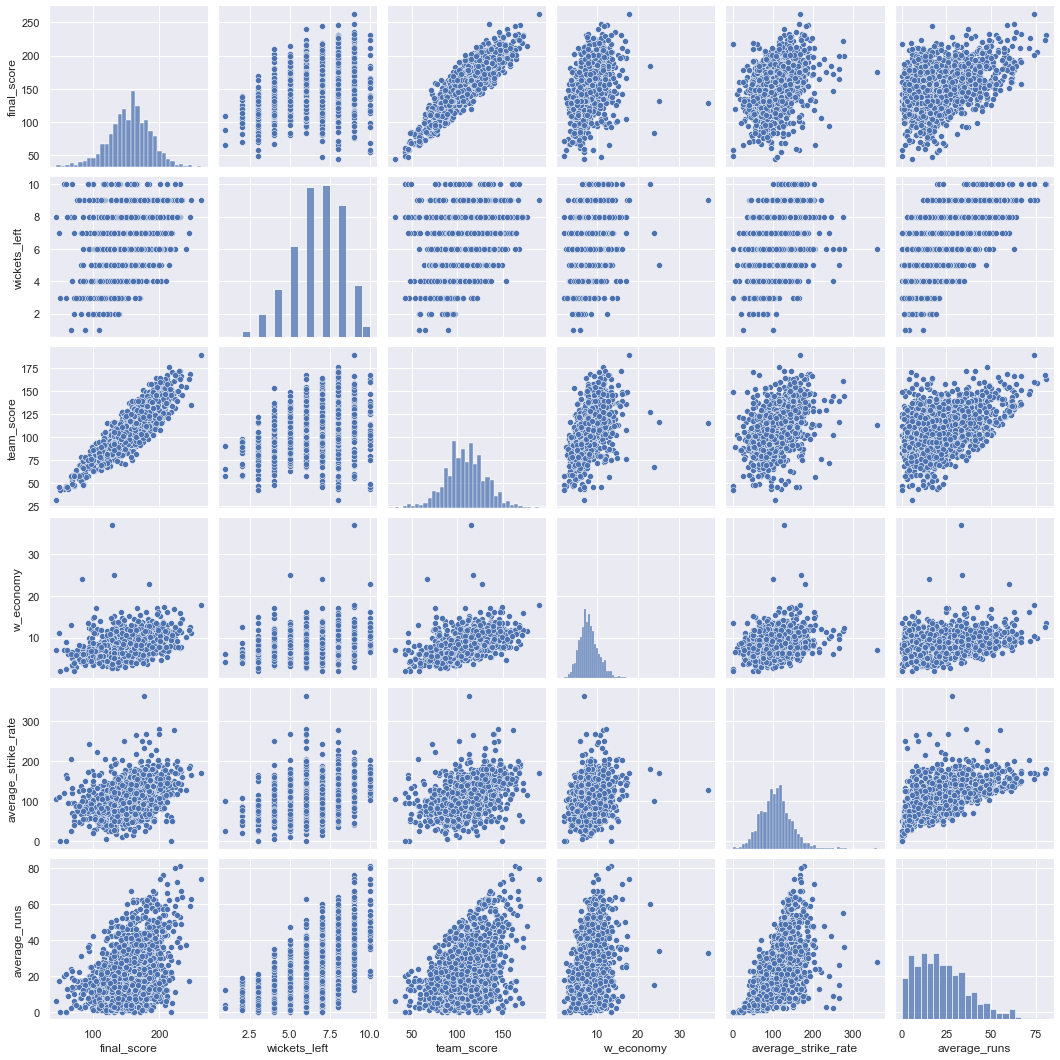

In [15]:
# Finding the Relationship between the Response variable and the Predictor variables
sb.pairplot(data = trainDF)

## Fitting the Random Forest Machine Learning Model

In [16]:
wickets_left2=[]
team_score2=[]
weighted_econ2=[]
final_score2=[]
avg_strike_rate2=[]
avg_runs2=[]
rforest_predictors = predictor_vars.copy()

for i in range(rforest_predictors.shape[0]):
    if(rforest_predictors['inning'][i]==2):
        wickets_left2.append(rforest_predictors['wickets_left'][i])
        team_score2.append(rforest_predictors['team_score'][i])
        weighted_econ2.append(rforest_predictors['w_economy'][i])
        final_score2.append(rforest_predictors['final_score'][i])
        avg_strike_rate2.append(rforest_predictors['average_strike_rate'][i])
        avg_runs2.append(rforest_predictors['average_runs'][i])
        
for i in rforest_predictors.index:
    if(i%2==1):
        rforest_predictors.drop(i,inplace=True)
rforest_predictors['wickets_left2']=wickets_left2
rforest_predictors['team_score2']=team_score2
rforest_predictors['w_economy2']=weighted_econ2
rforest_predictors['final_score2']=final_score2
rforest_predictors['average_strike_rate2']=avg_strike_rate2
rforest_predictors['average_runs2']=avg_runs2
rforest_predictors.drop(['inning'],axis=1,inplace=True)
rforest_predictors.reset_index(inplace=True, drop=True)

In [17]:
winner=[]
for i in range(0,rforest_predictors.shape[0]):
    if(rforest_predictors['final_score'][i] > rforest_predictors['final_score2'][i]):
        winner.append(1)
    else:
        winner.append(2)
rforest_predictors['winner'] = winner

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
y = pd.DataFrame(rforest_predictors["winner"])
X = pd.DataFrame(rforest_predictors[["wickets_left", "team_score", "w_economy", "average_runs", "average_strike_rate","wickets_left2", "team_score2", "w_economy2", "average_runs2", "average_strike_rate2"]])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
Random_model = RandomForestClassifier()
Random_model.fit(X_train,y_train.values.ravel())
y_train_pred = Random_model.predict(X_train)
y_test_pred = Random_model.predict(X_test)

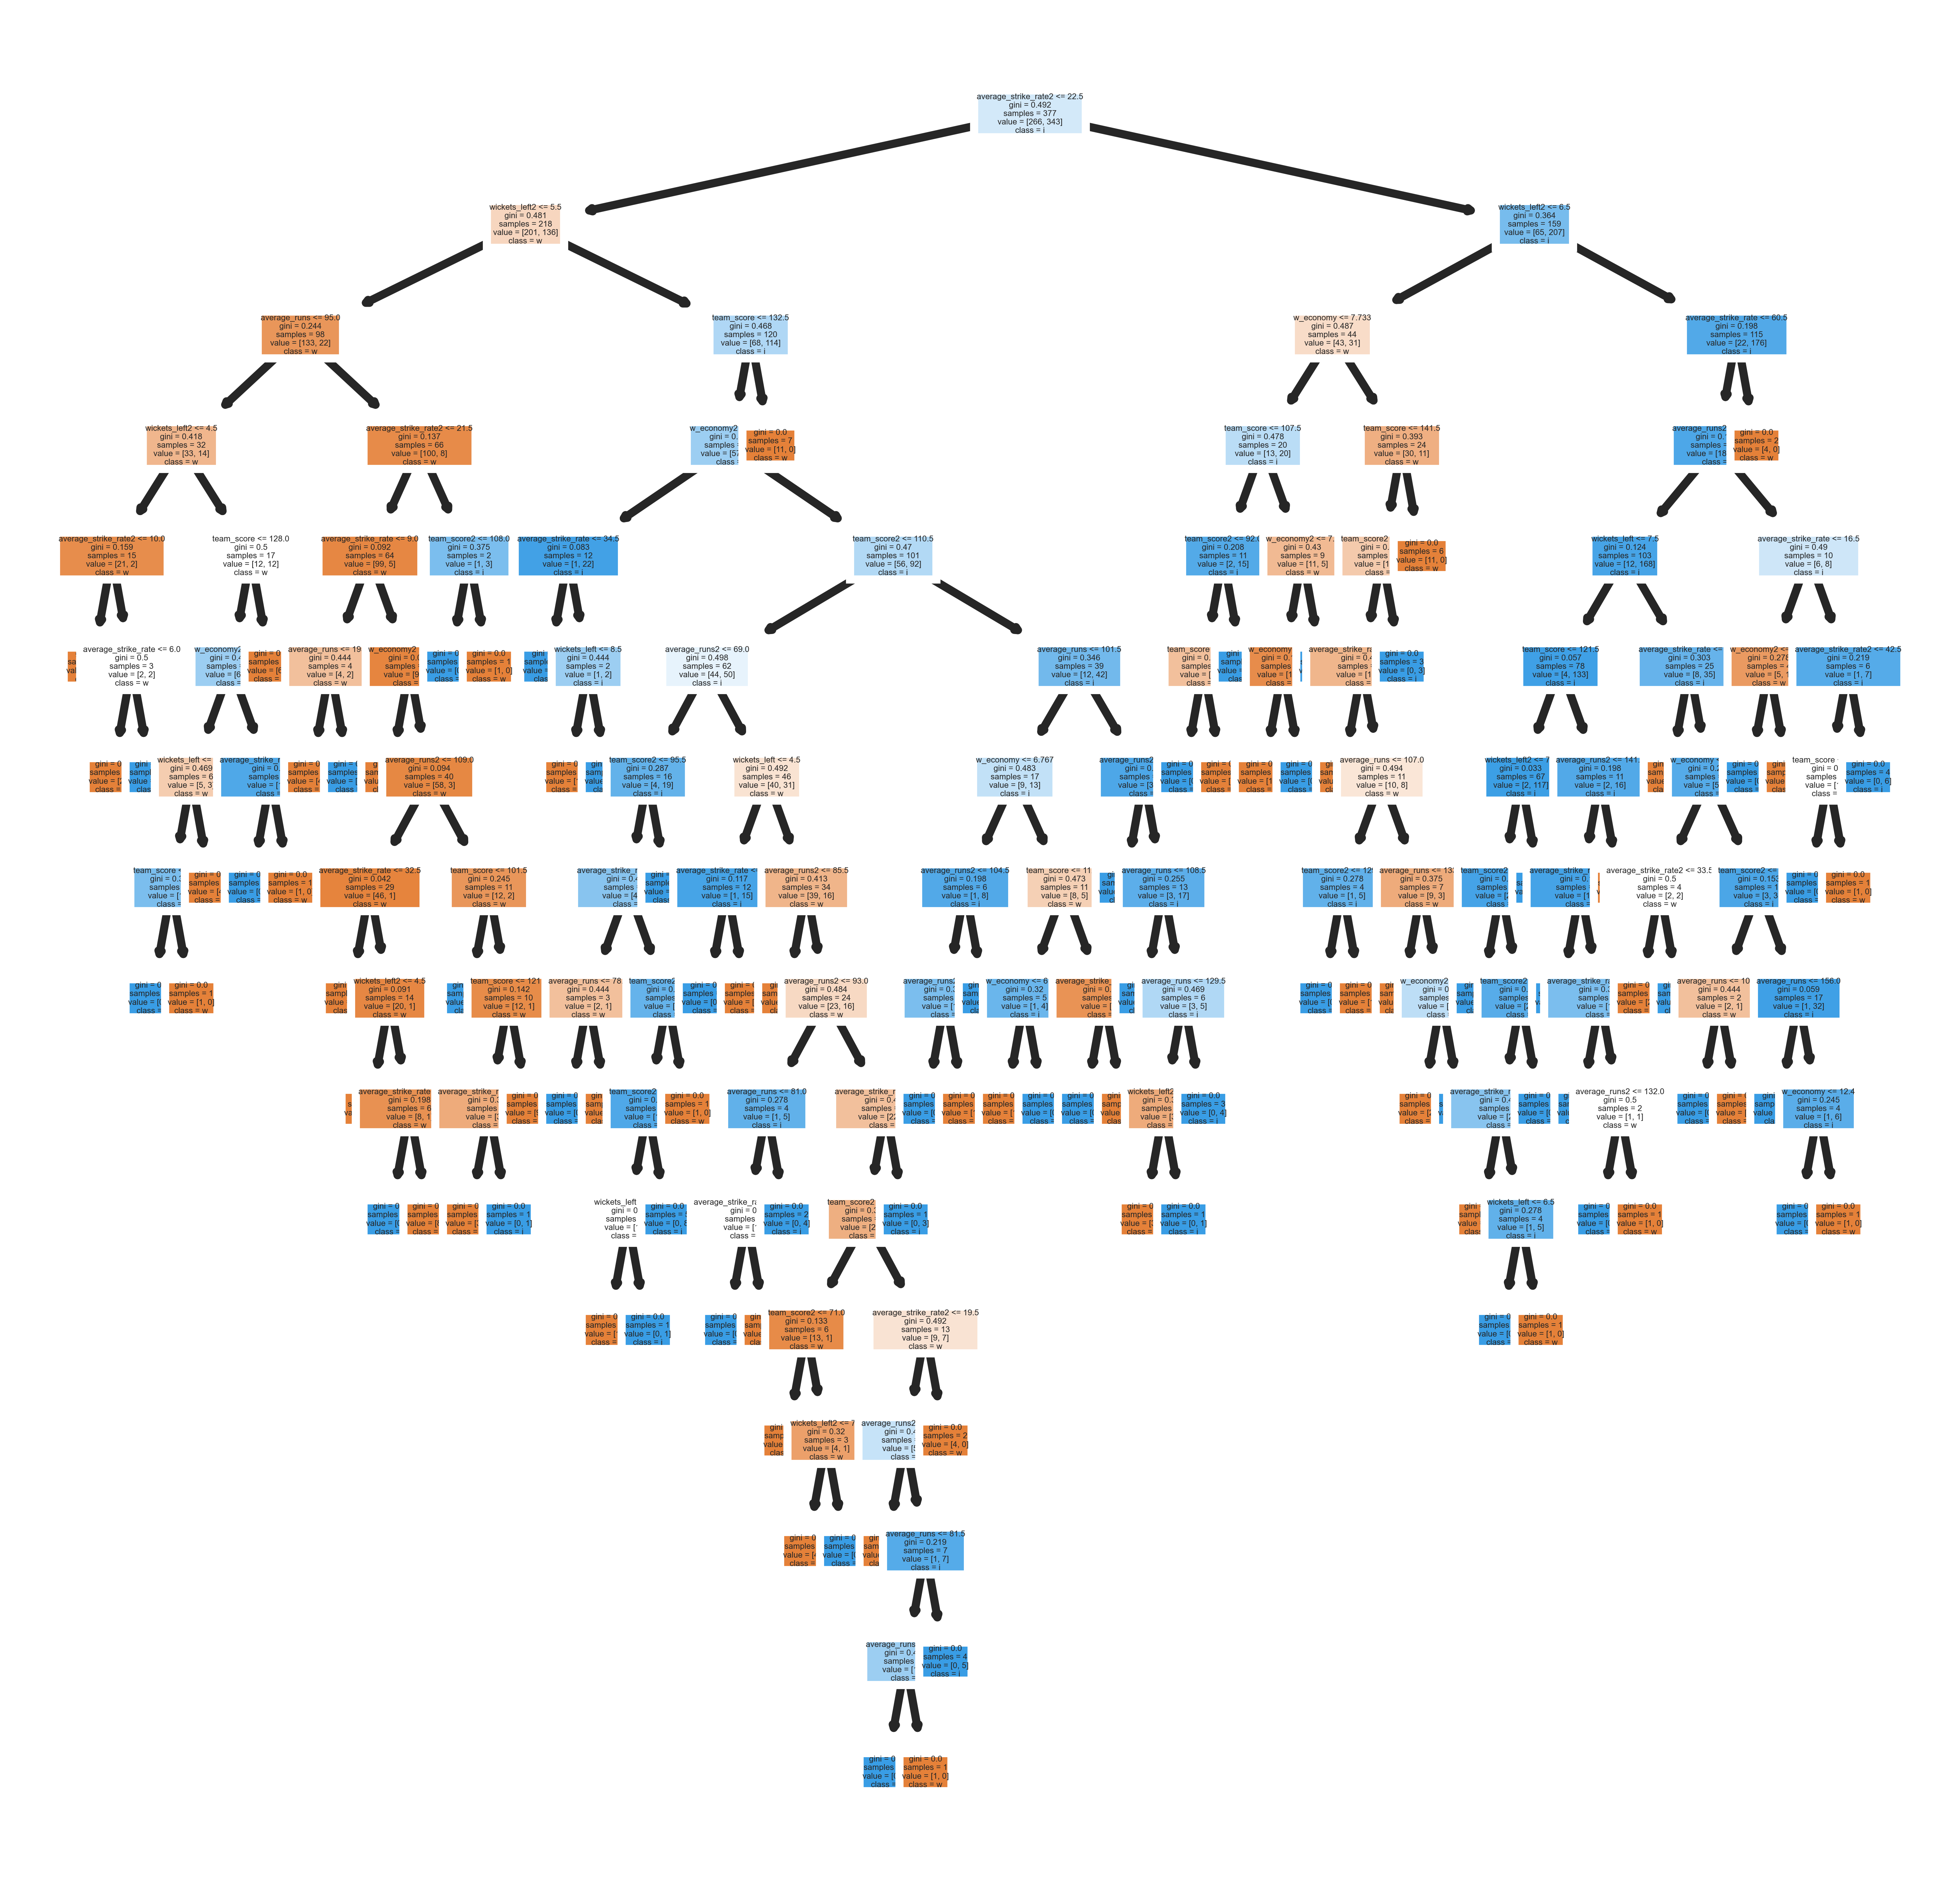

In [37]:
from sklearn.tree import export_graphviz
from sklearn import tree
from subprocess import call
from IPython.display import Image

# first decision tree
estimator = Random_model.estimators_[0]
fn=rforest_predictors.drop(['id','winner','final_score','final_score2'],axis=1).columns
cn='winner'

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=1600)
tree.plot_tree(estimator, feature_names = fn,
                class_names = cn,
                filled = True)
fig.savefig('rf_individualtree.png')

<AxesSubplot:>

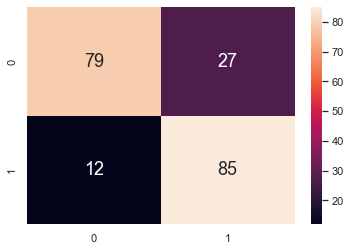

In [35]:
from sklearn.metrics import confusion_matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [36]:
from sklearn.metrics import accuracy_score
# Print the Classification Accuracy
print("Test Data:")
print("Accuracy  :\t", accuracy_score(y_test,y_test_pred))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Y (1) predicted Y (1)
fpTest = cmTest[0][1] # False Positives : N (0) predicted Y (1)
tnTest = cmTest[0][0] # True Negatives : N (0) predicted N (0)
fnTest = cmTest[1][0] # False Negatives : Y (1) predicted N (0)

print("True Positivity Rate Test :\t", (tpTest/(tpTest + fnTest)))
print("True Negativity Rate Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("False Positivity Rate Test :\t", (fpTest/(fpTest + tnTest)))
print("False Negativity Rate Test :\t", (fnTest/(fnTest + tpTest)))

Test Data
Accuracy  :	 0.8078817733990148

True Positivity Rate Test :	 0.8762886597938144
True Negativity Rate Test :	 0.7452830188679245

False Positivity Rate Test :	 0.25471698113207547
False Negativity Rate Test :	 0.12371134020618557


## Fitting the Multivariate Regression Machine Learning Model

In [27]:
# Extracting Response variable(final_score) and 
# Predictor variable(wickets left, team score, weighted economy, average runs, and average strike rate)
y = pd.DataFrame(predictor_vars["final_score"])
X = pd.DataFrame(predictor_vars[["wickets_left", "team_score", "w_economy", "average_runs", "average_strike_rate"]])

In [47]:
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split the Dataset into Train and Test
# We have used random train-test split with 75:25 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (1299, 1) (1299, 5)
Test Set  : (325, 1) (325, 5)


### Multiple Linear Regression using Scikit-Learn

In [ ]:
# Fitting the regression model and finding coefficients of the regression line
# Importing the LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression

# Multiple Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the regression model

# Coefficients and Intercepts of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
coeff_df = pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"])

> Regression Model : final_score = $c_1$ $\times$ wickets_left + $c_2$ $\times$ team_score + $c_3$ $\times$ w_economy + $c_4$ $\times$ average_runs + $c_5$ $\times$ average_strike_rate + $b$  

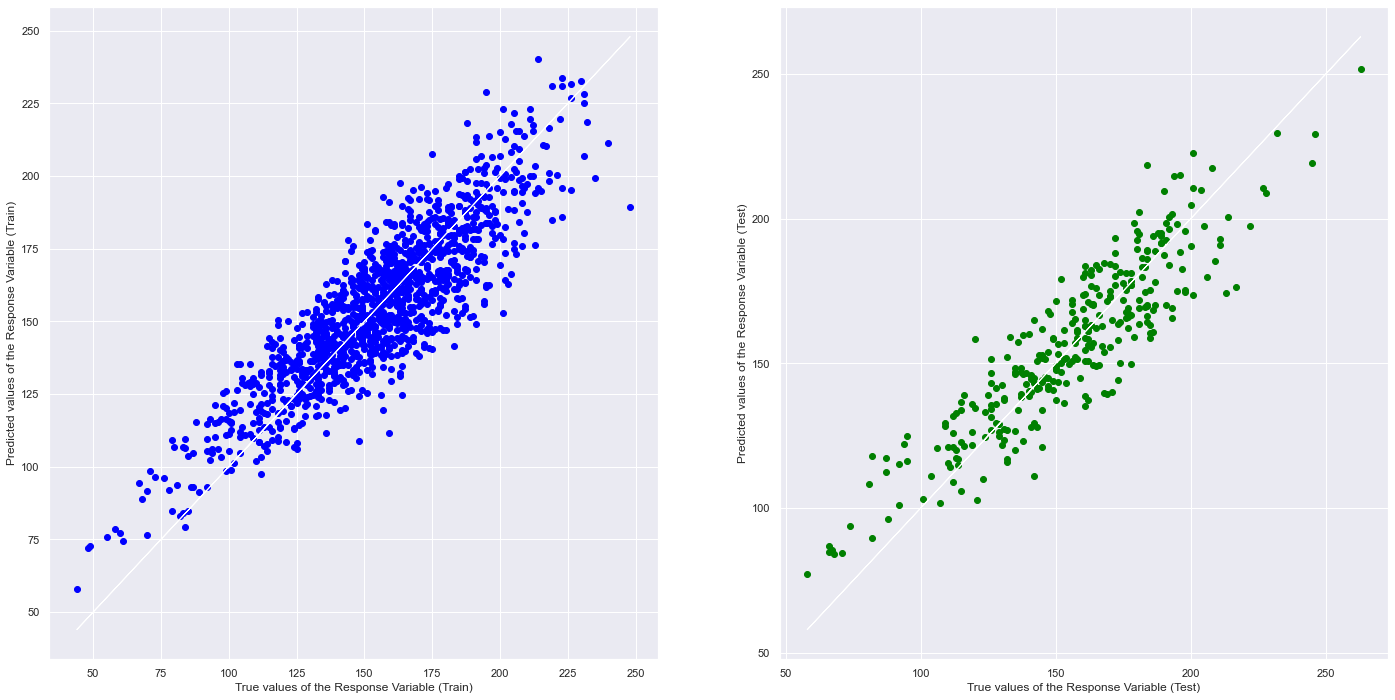

In [52]:
# Predict the Total(final score) values from Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

## Goodness of Fit to the model

In [53]:
# Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.763055115338761
Mean Squared Error (MSE) 	: 215.43892563933548

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.8115541996067172
Mean Squared Error (MSE) 	: 206.58977418276845



## Predicting the Match-winner

In [54]:
# Creating a dataframe with test data
testdf = pd.concat([X_test, y_test], axis = 1).reset_index()
# Creates dataframe with test data and match id
predictiondf = predictor_vars.iloc[testdf.index].reset_index(drop=True)
# Predicting final score using the regression equation and storing it in predictiondf
predictiondf['pred_final_score'] = predictiondf['wickets_left']*coeff_df['Coefficients'][0] + predictiondf['team_score']*coeff_df['Coefficients'][1]+predictiondf['w_economy']*coeff_df['Coefficients'][2]+predictiondf['average_strike_rate']*coeff_df['Coefficients'][3]+predictiondf['average_runs']*coeff_df['Coefficients'][4]

In [55]:
# Print dataframe with predictors, response, and predicted result
predictiondf

,id,inning,wickets_left,team_score,w_economy,average_strike_rate,average_runs,final_score,pred_final_score
0,335982,1,8,148,16.800000,151,50,222,184.686384
1,335982,2,2,58,4.250000,45,2,82,73.164644
2,335983,1,6,155,10.233333,128,37,240,197.753112
3,335983,2,7,159,10.600000,114,16,207,202.524007
4,335984,1,3,95,7.800000,82,4,129,119.148681
...,...,...,...,...,...,...,...,...,...
320,419151,1,6,107,7.066667,96,24,151,138.664880
321,419151,2,6,101,5.866667,78,8,138,131.376328
322,419152,1,7,107,6.933333,75,8,183,138.493583
323,419152,2,4,106,12.200000,66,7,144,128.045307


In [90]:
# Creating dataframe with match id and actual and predicted score of 2 innings of each match in test
outcomedf = 0
for i in predictiondf.index:
    if(i%2==0):
        new_temp = {'id':[predictiondf['id'][i]], 'score1':[int(predictiondf['final_score'][i])], 'pred1':[predictiondf['pred_final_score'][i]]}
    else:
        new_temp['score2'] = int(predictiondf['final_score'][i])
        new_temp['pred2'] = predictiondf['pred_final_score'][i]
        
        new_temp = pd.DataFrame(new_temp).copy()
        if(type(outcomedf) == int):
            outcomedf = pd.DataFrame(columns = ['id', 'score1', 'score2', 'pred1', 'pred2'])
            outcomedf = pd.concat([outcomedf, new_temp], axis = 0)
        else:
            outcomedf = pd.concat([outcomedf, new_temp], axis = 0)
outcomedf.reset_index(drop=True, inplace=True)

In [ ]:
#initializing columns to -1
outcomedf['winner_inn'] = -1
outcomedf['pred_winner_inn'] = -1
outcomedf['correct_pred'] = -1

# Comparing predicted score of each innings and predicting match winner
# outcomedf = outcomedf.copy(deep= True)
for i in outcomedf.index:
    if(outcomedf['score1'][i]>outcomedf['score2'][i]):
        outcomedf['winner_inn'][i] = 1
    else:
        outcomedf['winner_inn'][i] = 2
    
    if(outcomedf['pred1'][i]>outcomedf['pred2'][i]):
        outcomedf['pred_winner_inn'][i] = 1
    else:
        outcomedf['pred_winner_inn'][i] = 2

# Comparing predicted winner with actual winner and assigning 1 for correct prediction and 0 for incorrect prediction            
    if outcomedf['winner_inn'][i]==outcomedf['pred_winner_inn'][i]:
        outcomedf['correct_pred'][i] = 1
    else:
        outcomedf['correct_pred'][i] = 0
        

## Prediction model accuracy

In [59]:
# Computing prediction accuracy
correct = outcomedf['correct_pred'].sum()
pred_percent = 100*correct/outcomedf.shape[0]
print(pred_percent)

73.45679012345678
